In [6]:
#  Import necessary libraries

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/IoTProcessed_Data.csv')
df.head()

,date,tempreature,humidity,water_level,N,P,K,Fan_actuator_OFF,Fan_actuator_ON,Watering_plant_pump_OFF,Watering_plant_pump_ON,Water_pump_actuator_OFF,Water_pump_actuator_ON
0,2024-02-08 06:10:00,41,63,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
1,2024-02-08 06:15:00,41,59,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
2,2024-02-08 06:20:00,41,62,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
3,2024-02-08 06:05:00,40,60,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
4,2024-02-08 06:00:00,39,61,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0


In [4]:
# prompt: chek is any null value present in data is yes then use isNa and remove sum of Null values

# Check for null values
print(df.isnull().sum())

# If null values are present, handle them (e.g., remove rows with null values)
if df.isnull().values.any():
  df.dropna(inplace=True)


date                       2
tempreature                0
humidity                   0
water_level                0
N                          0
P                          0
K                          0
Fan_actuator_OFF           0
Fan_actuator_ON            0
Watering_plant_pump_OFF    0
Watering_plant_pump_ON     0
Water_pump_actuator_OFF    0
Water_pump_actuator_ON     0
dtype: int64


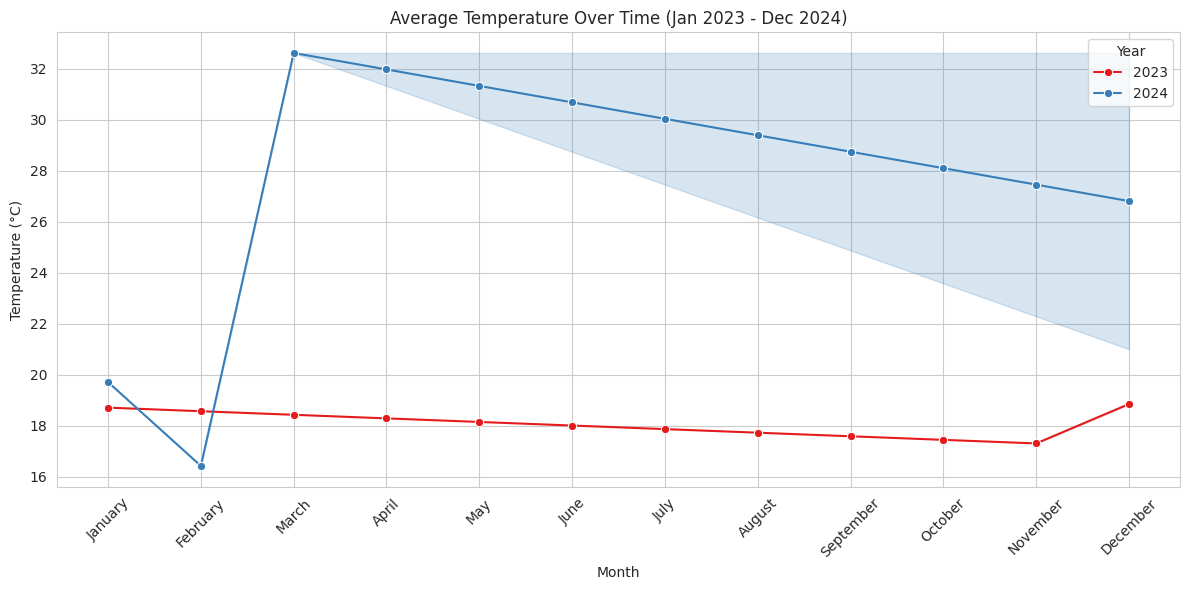

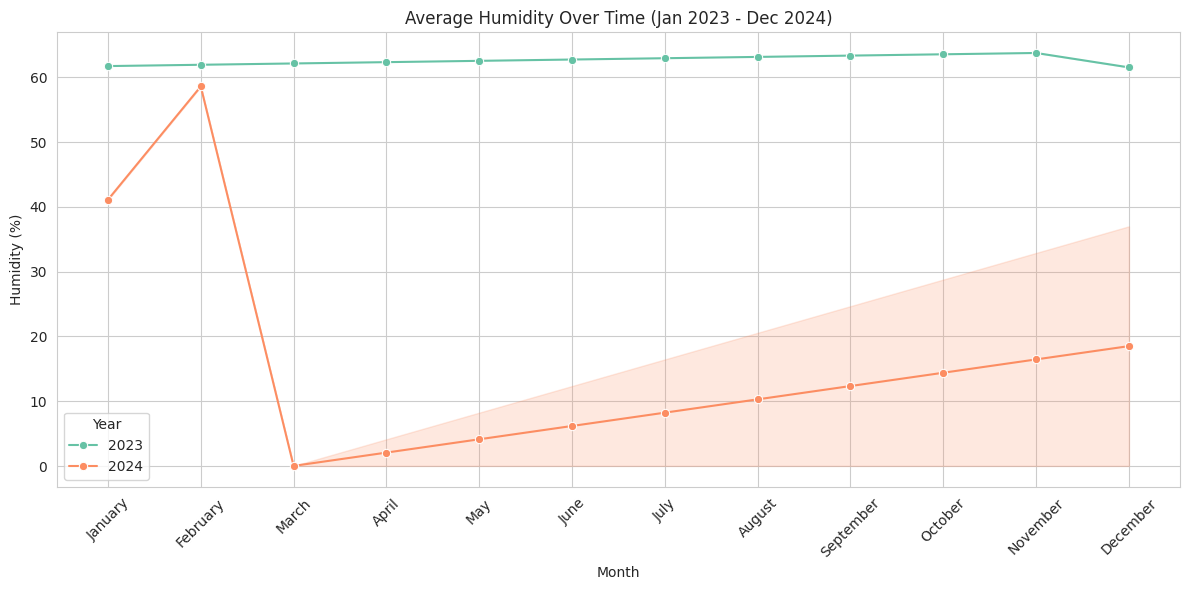

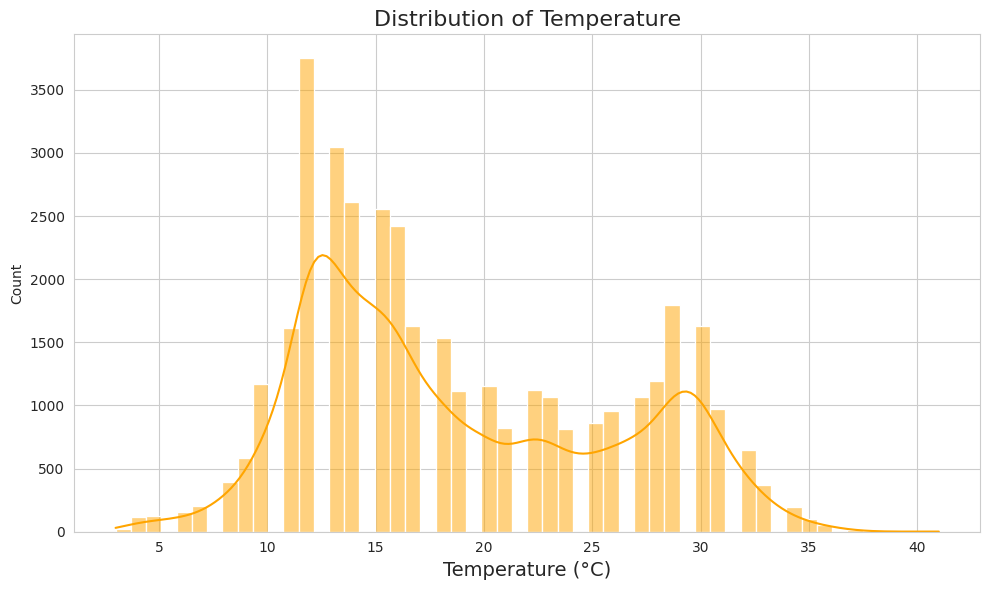

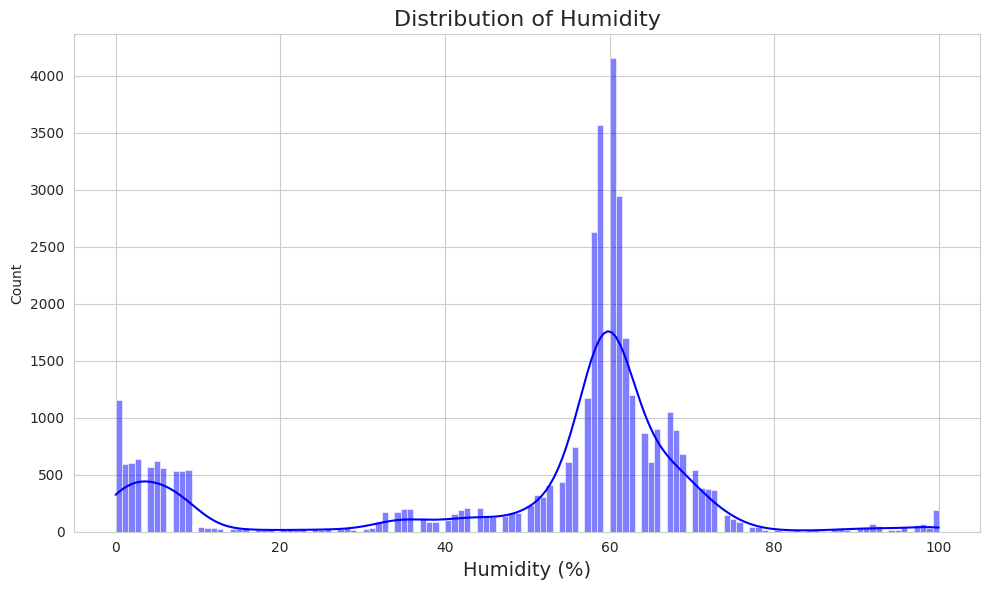

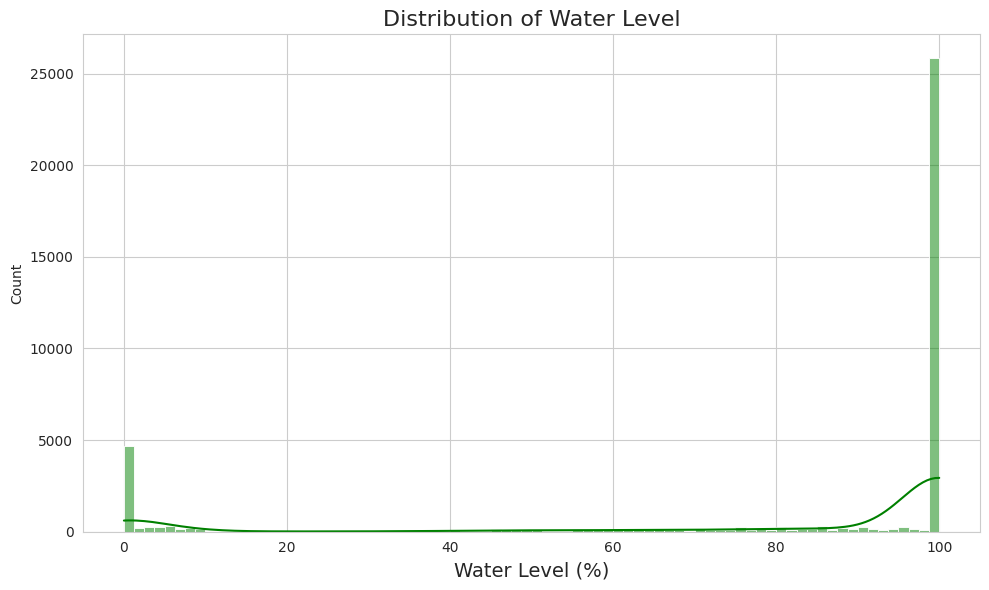

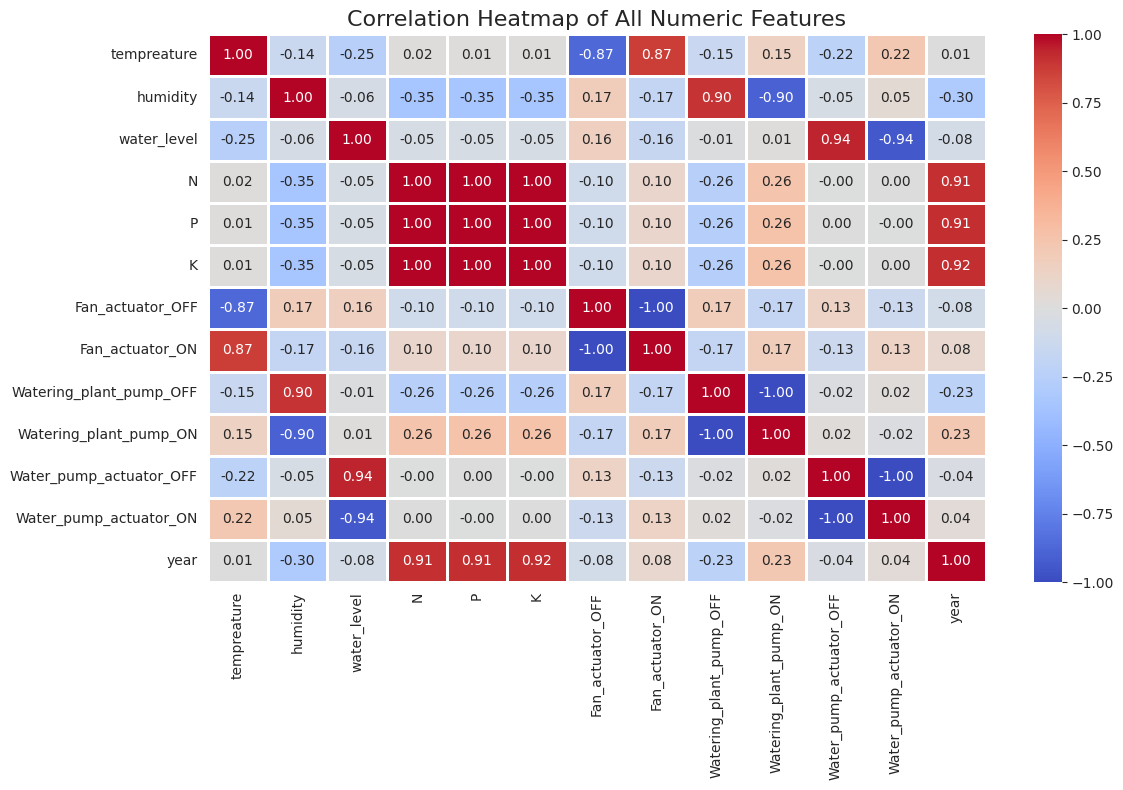

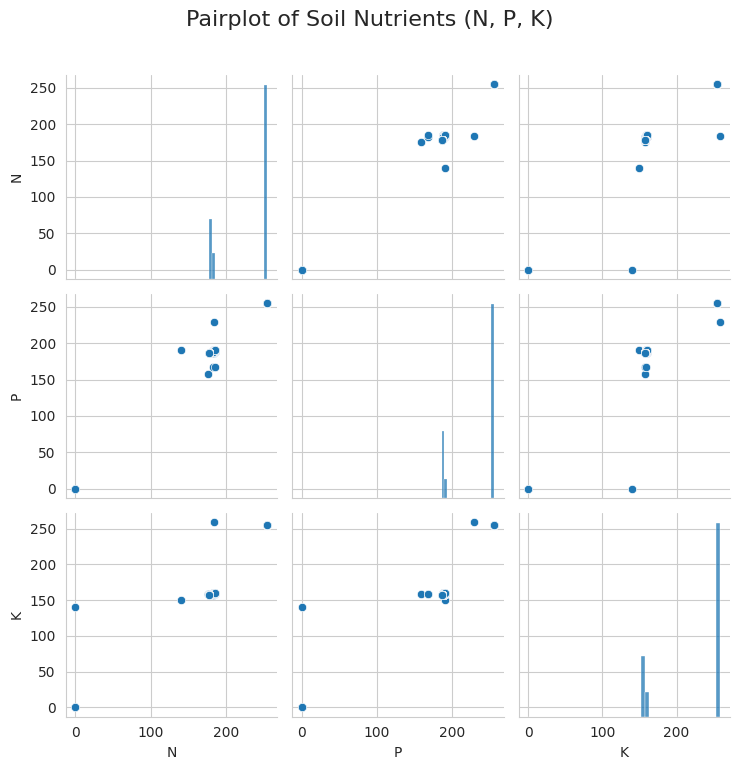

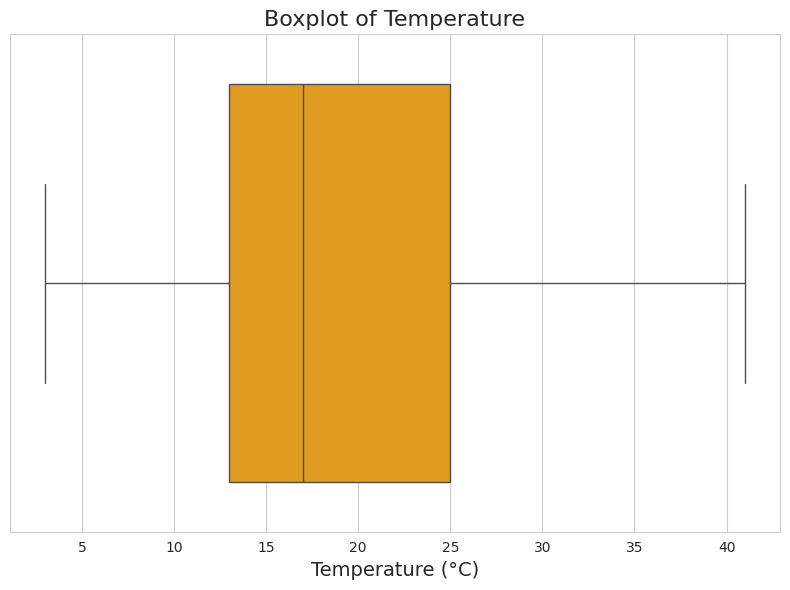

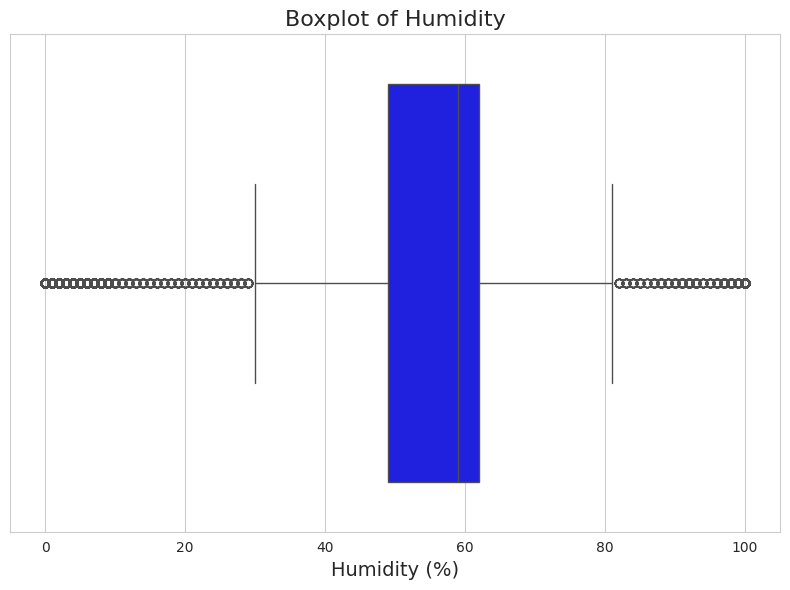

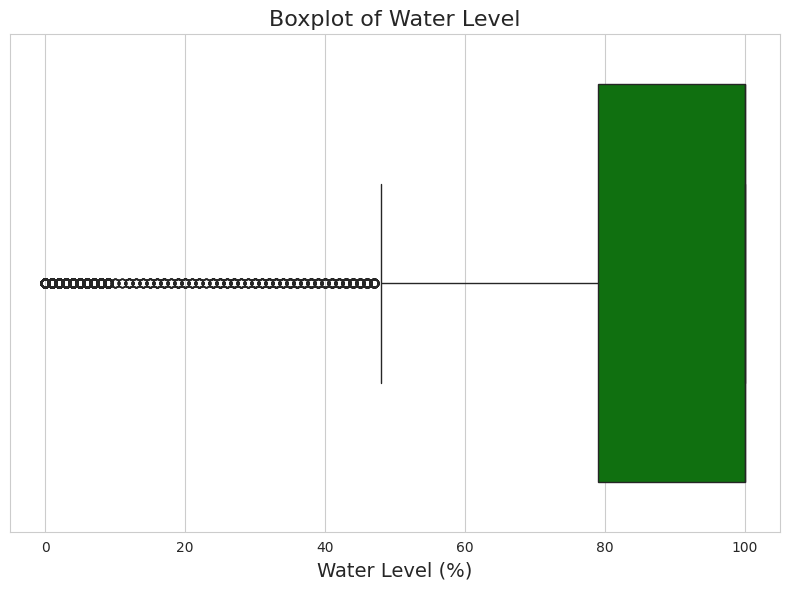

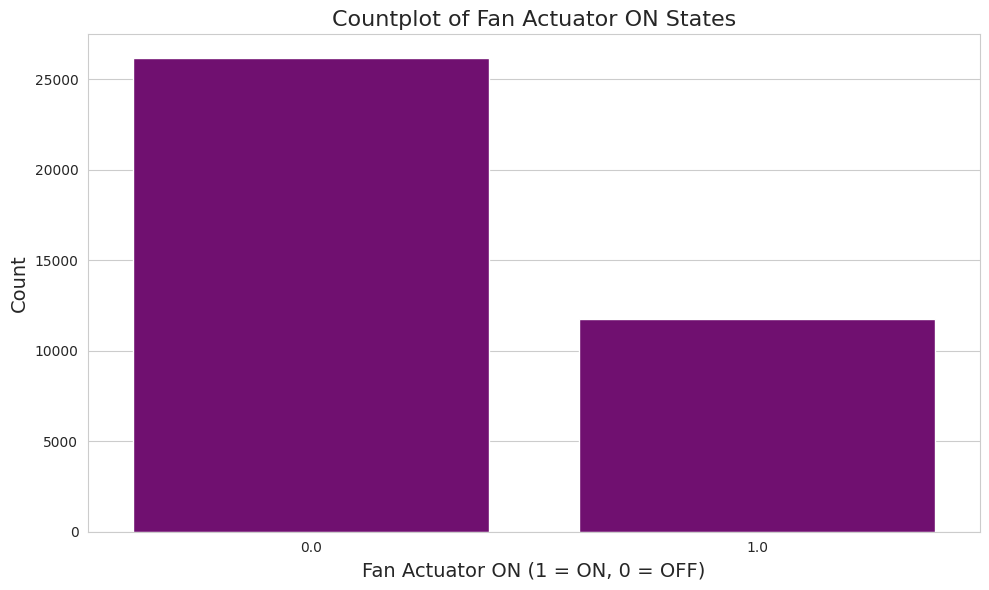

<ipython-input-7-476b23c1b121>:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Fan_actuator_ON', y='tempreature', data=df, palette='viridis')


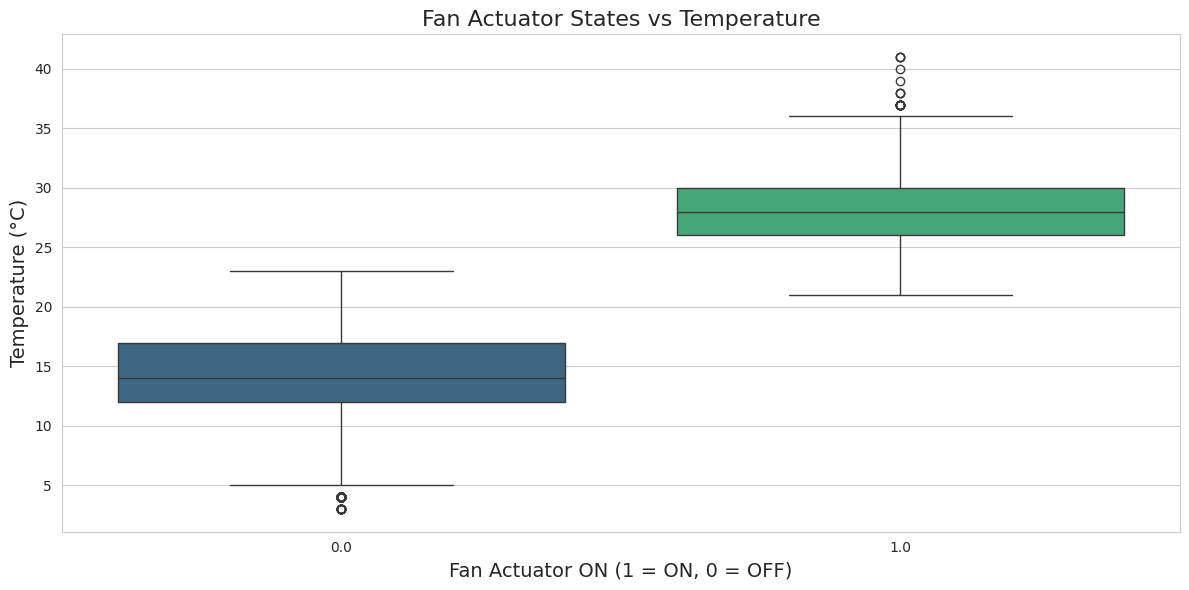

In [7]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])
# Set the visual style
sns.set_style("whitegrid")
# Extract month and year from the date
df['month'] = df['date'].dt.strftime('%B')  # Get month name
df['year'] = df['date'].dt.year  # Get year

# Function to calculate and plot average over time
def plot_monthly_average(df, column, ylabel, title, palette):
    # Group by year and month to calculate the mean of the specified column
    monthly_avg = df.groupby(['year', 'month'])[column].mean().reset_index()

    # Sorting by year and month for proper ordering in the plot
    monthly_avg['month_number'] = pd.to_datetime(monthly_avg['month'], format='%B').dt.month
    monthly_avg = monthly_avg.sort_values(['year', 'month_number'])

    # Create a complete range of months from Jan to Dec for each year in the dataset
    all_months = pd.date_range(start='2023-01-01', end='2024-12-31', freq='MS').strftime('%B').tolist()
    all_years = [2023, 2024]

    # Create a MultiIndex for all combinations of years and months
    full_index = pd.MultiIndex.from_product([all_years, all_months], names=['year', 'month'])

    # Reindex the DataFrame to ensure all months are present
    monthly_avg = monthly_avg.set_index(['year', 'month']).reindex(full_index).reset_index()

    # Fill any missing data with linear interpolation
    monthly_avg[column] = monthly_avg[column].interpolate(method='linear')

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=monthly_avg, x='month', y=column, hue='year', marker='o', palette=palette)
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title='Year')
    plt.tight_layout()
    plt.show()

# Plotting average temperature over time
plot_monthly_average(df, 'tempreature', 'Temperature (°C)', 'Average Temperature Over Time (Jan 2023 - Dec 2024)', 'Set1')

# Plotting average humidity over time
plot_monthly_average(df, 'humidity', 'Humidity (%)', 'Average Humidity Over Time (Jan 2023 - Dec 2024)', 'Set2')

# Plot 3: Distribution of Temperature
plt.figure(figsize=(10, 6))
sns.histplot(df['tempreature'], kde=True, color='orange')
plt.title('Distribution of Temperature', fontsize=16)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.tight_layout()
plt.show()

# Plot 4: Distribution of Humidity
plt.figure(figsize=(10, 6))
sns.histplot(df['humidity'], kde=True, color='blue')
plt.title('Distribution of Humidity', fontsize=16)
plt.xlabel('Humidity (%)', fontsize=14)
plt.tight_layout()
plt.show()

# Plot 5: Distribution of Water Level
plt.figure(figsize=(10, 6))
sns.histplot(df['water_level'], kde=True, color='green')
plt.title('Distribution of Water Level', fontsize=16)
plt.xlabel('Water Level (%)', fontsize=14)
plt.tight_layout()
plt.show()

# Plot 6: Correlation Heatmap
numeric_df = df.select_dtypes(include=[np.number])

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=2)
plt.title('Correlation Heatmap of All Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()

# Plot 7: Pairplot of Soil Nutrients (N, P, K)
sns.pairplot(df[['N', 'P', 'K']])
plt.suptitle('Pairplot of Soil Nutrients (N, P, K)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Plot 11: Boxplot of Temperature
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['tempreature'], color='orange')
plt.title('Boxplot of Temperature', fontsize=16)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.tight_layout()
plt.show()

# Plot 12: Boxplot of Humidity
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['humidity'], color='blue')
plt.title('Boxplot of Humidity', fontsize=16)
plt.xlabel('Humidity (%)', fontsize=14)
plt.tight_layout()
plt.show()

# Plot 13: Boxplot of Water Level
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['water_level'], color='green')
plt.title('Boxplot of Water Level', fontsize=16)
plt.xlabel('Water Level (%)', fontsize=14)
plt.tight_layout()
plt.show()

# Plot 14: Countplot of Fan Actuator States
plt.figure(figsize=(10, 6))
sns.countplot(x=df['Fan_actuator_ON'], color='purple')
plt.title('Countplot of Fan Actuator ON States', fontsize=16)
plt.xlabel('Fan Actuator ON (1 = ON, 0 = OFF)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tight_layout()
plt.show()

# Plot 15: Actuator States vs Temperature
plt.figure(figsize=(12, 6))
sns.boxplot(x='Fan_actuator_ON', y='tempreature', data=df, palette='viridis')
plt.title('Fan Actuator States vs Temperature', fontsize=16)
plt.xlabel('Fan Actuator ON (1 = ON, 0 = OFF)', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
# prepare the data

features = ['tempreature', 'humidity', 'water_level', 'N', 'P', 'K']
classification_targets = ['Fan_actuator_ON', 'Watering_plant_pump_ON', 'Water_pump_actuator_ON']
X = df[features]
y_classification = df[classification_targets]

# Convert multi-label to single label for multi-class classification
# Create a new single target column by combining the binary labels
y_classification['combined'] = y_classification.apply(lambda row: np.argmax(row.values), axis=1)

<ipython-input-9-101979afb1e9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_classification['combined'] = y_classification.apply(lambda row: np.argmax(row.values), axis=1)


In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_classification['combined'], test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, '/content/drive/MyDrive/scaler.pkl')

['/content/drive/MyDrive/scaler.pkl']

In [11]:
# Define models and train

models = {
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42)
}


In [26]:
# Define function for multi-class evaluation

def train_and_evaluate_multi_class(model, X_train, y_train, X_test, y_test):
    print(f"\nTraining {model.__class__.__name__} model for multi-class classification...")
    model.fit(X_train, y_train)

    # Predicting on test data
    y_pred = model.predict(X_test)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy}")

    # Classification Report
    report = classification_report(y_test, y_pred, target_names=classification_targets)
    print(f"Classification Report:\n{report}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classification_targets)

    # Plot confusion matrix with adjusted label rotation and padding
    plt.figure(figsize=(12, 10))  # Adjust the width and height as needed
    disp.plot(cmap=plt.cm.Blues)

    plt.title(f'{model.__class__.__name__} Confusion Matrix for Multi-Class')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees
    plt.yticks(rotation=0)  # Keep y-axis labels horizontal

    plt.tight_layout(pad=2.0)  # Adjust padding between the plot and labels
    plt.show()

    # ROC Curve
    if hasattr(model, "predict_proba"):
        # Compute ROC curve and ROC area for each class
        y_prob = model.predict_proba(X_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(len(classification_targets)):
            fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot ROC Curve
        plt.figure()
        for i in range(len(classification_targets)):
            plt.plot(fpr[i], tpr[i], label=f'ROC Curve for {classification_targets[i]} (area = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model.__class__.__name__} ROC Curve for Multi-Class')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()



Training GradientBoostingClassifier model for multi-class classification...
Test Accuracy: 0.9955168776371308
Classification Report:
                        precision    recall  f1-score   support

       Fan_actuator_ON       1.00      1.00      1.00      5731
Watering_plant_pump_ON       1.00      1.00      1.00       976
Water_pump_actuator_ON       0.98      0.98      0.98       877

              accuracy                           1.00      7584
             macro avg       0.99      0.99      0.99      7584
          weighted avg       1.00      1.00      1.00      7584



<Figure size 1200x1000 with 0 Axes>

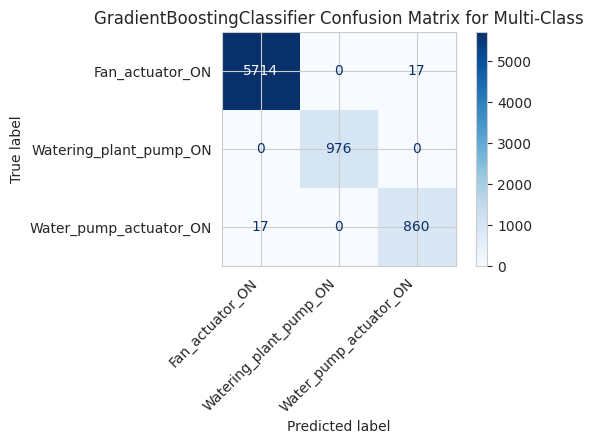

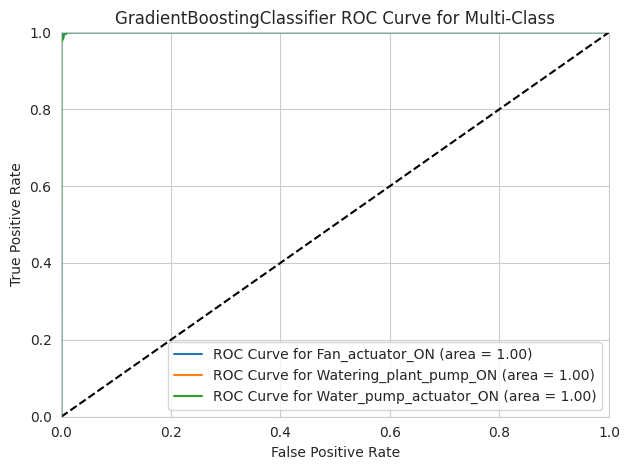

In [27]:
# Evaluate Gradient Boosting Classifier

model = models['Gradient Boosting']
train_and_evaluate_multi_class(model, X_train, y_train, X_test, y_test)



Training RandomForestClassifier model for multi-class classification...
Test Accuracy: 0.9961761603375527
Classification Report:
                        precision    recall  f1-score   support

       Fan_actuator_ON       1.00      1.00      1.00      5731
Watering_plant_pump_ON       1.00      1.00      1.00       976
Water_pump_actuator_ON       0.98      0.98      0.98       877

              accuracy                           1.00      7584
             macro avg       0.99      0.99      0.99      7584
          weighted avg       1.00      1.00      1.00      7584



<Figure size 1200x1000 with 0 Axes>

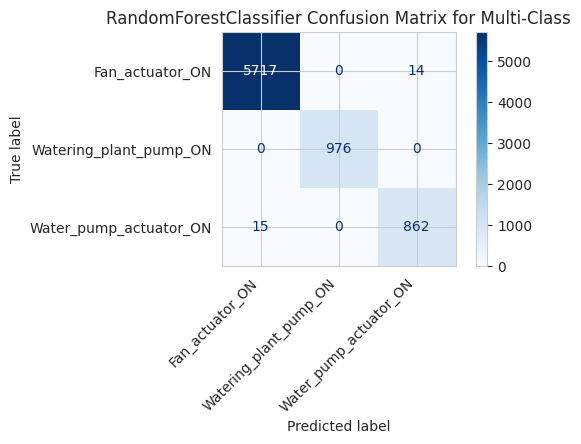

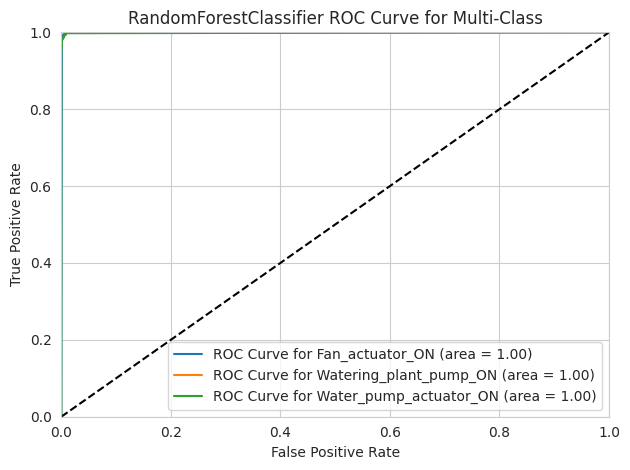

In [28]:
#Evaluate Random Forest Classifier

model = models['Random Forest']
train_and_evaluate_multi_class(model, X_train, y_train, X_test, y_test)



Training SVC model for multi-class classification...
Test Accuracy: 0.9533227848101266
Classification Report:
                        precision    recall  f1-score   support

       Fan_actuator_ON       0.95      0.99      0.97      5731
Watering_plant_pump_ON       0.97      0.83      0.90       976
Water_pump_actuator_ON       0.94      0.87      0.90       877

              accuracy                           0.95      7584
             macro avg       0.95      0.90      0.92      7584
          weighted avg       0.95      0.95      0.95      7584



<Figure size 1200x1000 with 0 Axes>

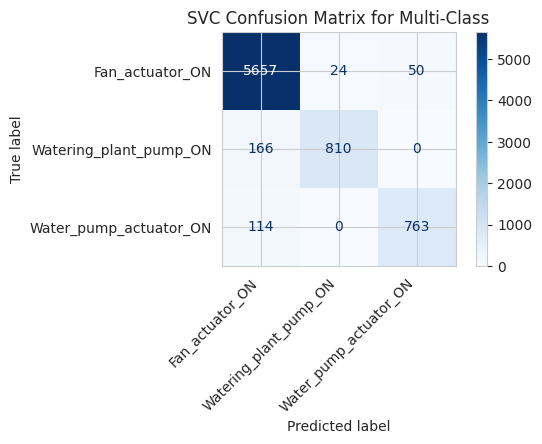

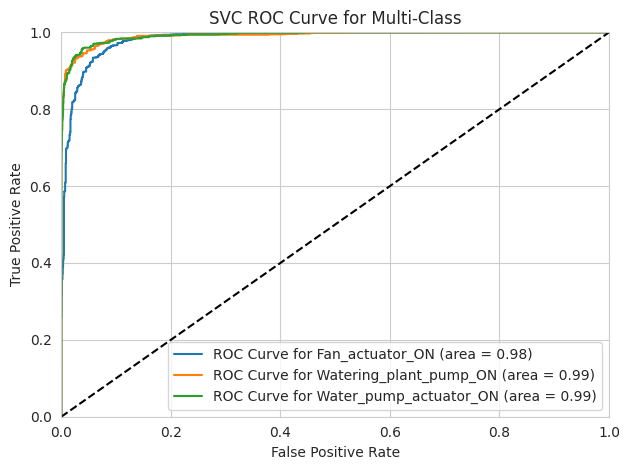

In [29]:
#Evaluate Support Vector Machine (SVM)

model = models['SVM']
train_and_evaluate_multi_class(model, X_train, y_train, X_test, y_test)


In [34]:
# Save the trained Random Forest model
model_filename = '/content/drive/MyDrive/random_forest_model.pkl'
joblib.dump(models['Random Forest'], model_filename)

['/content/drive/MyDrive/random_forest_model.pkl']